In [177]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [178]:
import nest_asyncio
nest_asyncio.apply()

In [179]:
from pydantic import BaseModel
from playwright.async_api import Page
from typing import Literal, List, TypedDict, Annotated
from pydantic import Field
from operator import add




class Bbox(TypedDict):
    id: int
    x: float
    y: float
    type: str
    text: str
    arialabel: str

class ImageScreenShoot(TypedDict):
    img : str
    bboxes : List[Bbox]

class Action(TypedDict):
    action: Literal["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter"]
    text_to_type: str = Field(..., description="The text to be typed into the element if the action is type_text")
    bbox: Bbox
    description: str = Field(..., description="A short description of the action to be performed")

class AnswerNode(TypedDict):
    answer: str

class MasterPlanState(TypedDict):
    plan: List[str]



class AgentState(TypedDict):
    task: str
    page: Page
    master_plan: MasterPlanState
    next_tool_action: Action
    actions_executed: Annotated[List[str], add]
    last_tool_action: str
    answer: AnswerNode
    notes: Annotated[List[str], add]
    status: Literal["in_progress", "completed"]


In [180]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io


with open("mark_page.js") as f:
    mark_page_script = f.read()

async def is_image_blank(image_bytes: bytes) -> bool:
    """Return True if the screenshot is fully blank (e.g. all white), else False."""
    if not image_bytes:
        return True
    img = PILImage.open(io.BytesIO(image_bytes)).convert("L")
    # If getbbox() returns None, the image is entirely one color
    return img.getbbox() is None

async def capture_screenshot(page: Page, max_retries=3, wait_seconds=2) -> bytes:
    """Take a screenshot, retry if blank (completely white)."""
    screenshot_bytes = b""
    for attempt in range(max_retries):
        # Wait for the page to be fully loaded
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot
        screenshot_bytes = await page.screenshot(path="screenshot.png")
        
        # Check if it's blank
        if not await is_image_blank(screenshot_bytes):
            return screenshot_bytes
        
        # If blank, wait a bit and retry
        print(f"[capture_screenshot] Screenshot is blank (attempt {attempt+1}/{max_retries}). Retrying...")
        await asyncio.sleep(wait_seconds)
    
    # If we get here, all attempts yielded a blank screenshot
    print("[capture_screenshot] All screenshot attempts were blank.")
    return screenshot_bytes  # Return whatever we got last


async def mark_page(page):

    """
    1. Wait for the page to be loaded using 'networkidle'.
    2. Attempt to run a 'mark_page_script' that presumably marks and returns bounding boxes.
    3. Retry up to 10 times if it fails.
    4. Capture a screenshot with retry logic (up to 3 tries) if the page is blank.
    5. Process screenshot (grayscale, resize, quantize, compress).
    6. Remove the markings before returning.
    """

    bboxes = List[Bbox]

    for attempt in range (10):
        try: 
            await page.wait_for_load_state("networkidle")

            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            break
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/10 failed to mark page: {e}")
            await asyncio.sleep(3)
    # Get screenshot as bytes
    await page.wait_for_load_state("networkidle")
    screenshot_bytes = await capture_screenshot(page, max_retries=3)
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        # Convert to grayscale
        img = img.convert('L')
        # Resize
        max_size = (300, 300)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        # Quantize and convert back to grayscale
        img = img.quantize(colors=16).convert('L')
        
        # Compress
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=5,      # Low quality -> smaller size
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        # If screenshot is empty or never taken, handle gracefully
        print("[mark_page] Using empty screenshot due to failure or blank screenshot.")
        compressed_bytes = b""

    await page.wait_for_load_state("networkidle")
    try:
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"[mark_page] Could not unmark page: {e}")

    # Build final result
    return ImageScreenShoot(
        img=base64.b64encode(compressed_bytes).decode("utf-8"),
        bboxes=bboxes
    )

In [192]:
from langchain_core.tools import Tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import AIMessage, HumanMessage
import platform
from pprint import pprint

async def click_element(agent_state: AgentState):
    """Click on a specified element on the webpage using its bounding box coordinates.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    """
    print("********************CLICK ELEMENT TOOL********************\n")

    page = agent_state["page"]
    
    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
   
    await page.mouse.click(bbox["x"], bbox["y"])
    await page.wait_for_load_state("domcontentloaded")

    bbox_text = bbox["text"]
    bbox_id = bbox["id"]    
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "clicked element"
    return { "last_tool_action": f"{description}. (clicked element with id {bbox_id} and text {bbox_text})", "actions_executed": [description]} # Return string, not dict



async def scroll_element(agent_state: AgentState):
    """Scroll the webpage up or down.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
   
    """
    print("********************SCROLL TOOL********************\n")
 
    page = agent_state["page"]
    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    await page.mouse.wheel(0, 500)
    await page.wait_for_load_state("domcontentloaded")
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "scrolled element"
    return {"last_tool_action": f"{description}. (scrolled element)", "actions_executed": [description]} # Return string, not dict


async def type_text(agent_state: AgentState):
    """Type text into a specified element on the webpage.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************TYPE TEXT TOOL********************\n")

    page = agent_state["page"]

    next_tool_action = agent_state["next_tool_action"]
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(next_tool_action)
    print("----------------------------------------------------------\n")
    bbox = next_tool_action["bbox"]
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(next_tool_action["text_to_type"])
    await page.keyboard.press("Enter")
    await asyncio.sleep(2)
    await page.wait_for_load_state("domcontentloaded")
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "typed text into element"
    return {"last_tool_action": f"{description}. (typed text into element with id {bbox_id} and text {bbox_text})", "actions_executed": [description]} # Return string, not dict


async def wait(agent_state: AgentState):
    print("********************WAIT NODE********************\n")

    sleep_time = 5
    await asyncio.sleep(sleep_time) 
    next_tool_action = agent_state["next_tool_action"]
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "waited for 5 seconds"
    return {"last_tool_action": f"{description}. (waited for {sleep_time} seconds)", "actions_executed": [description]} # Return string, not dict

async def go_back(agent_state: AgentState):
    print("********************GO BACK NODE********************\n")

    await agent_state["page"].go_back()
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    next_tool_action = agent_state["next_tool_action"] 
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "went back to the previous page"
    return { "last_tool_action": f"{description}. (went back to the previous page)", "actions_executed": [description]} # Return string, not dict

async def go_to_google(agent_state: AgentState):
    print("********************GO TO GOOGLE NODE********************\n")

    next_tool_action = agent_state["next_tool_action"]
    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "went to google"
    await agent_state["page"].goto("https://www.google.com")
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    return {"last_tool_action": f"{description}. (went to google)", "actions_executed": [description]} # Return string, not dict

async def press_enter(agent_state: AgentState):
    print("********************PRESS ENTER NODE********************\n")
    
    next_tool_action = agent_state["next_tool_action"]

    if next_tool_action["description"]:
        description = next_tool_action["description"]
    else:
        description = "pressed enter"
    await agent_state["page"].keyboard.press("Enter")
    await agent_state["page"].wait_for_load_state("domcontentloaded")
    return {"last_tool_action": f"{description}. (pressed enter)", "actions_executed": [description]} # Return string, not dict


In [193]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

async def master_plan_node(state: AgentState):
    print("********************MASTER PLAN NODE********************\n")

    screen_shot = await mark_page(state["page"])
    

    system_message = """
    You are an expert a preparing a step by step plan to complete a task.
    You will be given a task provided by the user. The task might also be a question.
    You will need to prepare a plan to complete the task. In case its a question, you will need to prepare a plan to answer the question.

    You will be also provided the screenshot of the current web page.
    - If the current page is google home page or any other search engine, create a plan that basically searches the keyword and continues to the next step.
    - If the current page is not a some other web page, create a plan to scroll through the page and relevant collect information. 

    For eg if the task is "What is the lastest news on Apple's stock price?", you will need to prepare a plan to answer the question.
    You will need to prepare a plan to complete the task.

    For example, if the task is "What is the latest news on Apple's stock price?", your plan might look like this:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    Your plan should be clear, sequential, and focused on achieving the user's goal efficiently. 

    --Notes--
    The browser is already open. First page will always be google, so plan accordingly with a search term.
    For any question, you will need to go to google and search for the question.
    """ 

    human_prompt = """ This is the task that needs to be performed/question that needs to be answered: {task} \n This is the screenshot of the current web page: {screenshot}"""

    task = state["task"]

    human_message = human_prompt.format(task=task, screenshot=screen_shot)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]
    structured_llm = llm.with_structured_output(MasterPlanState)

    response = structured_llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Master Plan:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"master_plan": [response], "status": "in_progress"}



In [194]:
async def next_tool_action_node(state: AgentState):
    
    print("********************NEXT TOOL ACTION NODE********************\n")

    
    screen_shot = await mark_page(state["page"])

   
    system_message = """ 
    You are an helpful assistant that can take in a broader master plan identify the next action that needs to be performed on the current web page.
    Carefully analyze the current web page contents from the screenshot and the master plan to decide the next action.
   
    To identify the next action, you will be given :
    - the master plan
    - a screenshot of the current web page
    - the actions that has been executed so far (if any)
    - last action that was specifically executed

    The tools you have are - 
    1. click_element - click on a specified element on the webpage using its bounding box coordinates.
    2. scroll_element - scroll the webpage down.
    3. type_text - type text into a specified element on the webpage.
    4. wait - wait for a specified amount of time.
    5. go_back - go back to the previous page.
    6. go_to_google - go to google.
    7. press_enter - press enter.

    Notes:
    - The next action should be strictly restriced to the current web page whose screenshot is provided.
    - The action should be as atomic as possible and should be a single step. For eg:
        - If you type text in an input field, the next action should be "press_enter"
    - Clearly try to understand how a human would surf the web to complete the task to decide the next step.
    - Remeber that master plan is a broader plan that is just to guide you. You need to decide the next action based on the current web page screenshot. If you encounter something you must to continue surfing the web accoring to master plan but not mentioned in the master plan, you should do it.
        - For eg if you search for a term in google maps and to fulfill the master plan, you need to hit a button saying directions to the later type in destinationin further steps, do so.
        - Try to think of how a human would surf the web to complete the task. Break down the task into smaller steps and decide the next action based on the current web page screenshot to complete the master plan.
    
    For eg if the master plan is:
    1. Go to Google
    2. Type "Apple stock price news today" in the search bar and press enter
    3. Scroll through the results page and click on the link to the reliable financial news source (like Reuters, Bloomberg, or CNBC).
    4. Scan the article for current stock price and recent developments
    5. If you have enough information, prepare a concise summary of the latest news and price movement
    6. If you do not have enough information, go back to the previous page and try a different source and collect more data until you have enough information to answer the question.

    If the screenshot of the current web page is a search engine home page:
    1. No actions have been performed so far, current action should be: Click on the search bar
    2. If search bar is already clicked, current action should be: Type "Apple stock price news today" in the search bar
    3. If search bar is already clicked and text is already typed, current action should be: Press enter

    If the screenshot of the current web page is a search engine results page:
    1. No actions have been performed so far and you dont have any relevant links, current action should be: scroll window down (repeat this action until you find a relevant link, or you have scrolled down the entire page)
    2. No actions have been performed so far and you have relevant links, current action should be: click on a relevant link
    3. If you have already visited any link(s) in the previous actions, current action should be: scroll window down to collect more information (repeat this action until you have scrolled down the entire page or you have found a relevant link which you have not clicked on yet)
    4. If you have already visited any link(s) in the previous actions and found a new relevant link you have not clicked on yet, current action should be: click on the new relevant link
    
    
    If the screenshot is of a some other web page, the current plan should be:
    1. No actions have been performed so far or some actions have been performed so far to bring you to this page, current action should be: scroll window down (repeat this action until you have scrolled down the entire page)
    2. If you have already scrolled down the entire page, current action should be: go back to the previous page
    3. If you have already gone back to the previous page and see a search engine results page in the screenshot, current action should be: scroll window down (repeat this action until you have scrolled down the entire page or you have found a relevant link)
    4. If you have already clicked on a relevant link, current action should be: scroll window down to collect more information (repeat this action until you have scrolled down the entire page)
    5. If you have already gone back to the previous page and dont see a search engine results page in the screenshot, current action should be: go to google
    
   
    Think of how a human would surf the web to complete the task.
    """

    human_prompt = """ 
    This is the master plan : {master_plan}
    This is the screenshot of the current web page: {screenshot}
    This is the actions that have been executed so far: {actions_executed}
    This is the last action that was specifically executed: {last_action}
    """

    master_plan = state["master_plan"]
    actions_executed = state["actions_executed"]
    last_action = state["last_tool_action"]
    human_message = human_prompt.format(master_plan=master_plan, screenshot=screen_shot, actions_executed=actions_executed, last_action=last_action)

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=human_message)
    ]

    print(messages)
    
    structured_llm = llm.with_structured_output(Action)
    response = structured_llm.invoke(messages)
    print("----------------------------------------------------------\n")
    print("Next Tool Action:")
    pprint(response)
    print("----------------------------------------------------------\n")

    return {"next_tool_action": response, "status": "in_progress"}


In [195]:
from langgraph.graph import StateGraph, START, END



async def should_call_tool(state: AgentState):
    next_tool_action = state["next_tool_action"]
    next_tool_action_type = next_tool_action["action"]

    if next_tool_action_type == "click_element":
        return "click_element"
    elif next_tool_action_type == "scroll_element":
        return "scroll_element"
    elif next_tool_action_type == "type_text":
        return "type_text"
    elif next_tool_action_type == "wait":
        return "wait"
    elif next_tool_action_type == "go_back":
        return "go_back"
    elif next_tool_action_type == "go_to_google":
        return "go_to_google"
    elif next_tool_action_type == "press_enter":
        return "press_enter"
    else:
        ValueError(f"Invalid action: {next_tool_action_type}")



In [196]:
async def update_notes_node(state: AgentState):
    print("********************UPDATE NOTES NODE********************\n")

    screen_shot = await mark_page(state["page"])
    task = state["task"]
    system_prompt = """ 
    You are an expert at taking down notes from a web page.
    You will be given a screenshot of the current web page and the task that needs to be performed/question that needs to be answered to by completing a task for the user.

    Based on the task provided, try to analyze the relevant information from the screenshot of the web page and take down notes.

    If you are not able to find any relevant information, return "NO_NOTES".

    """

    human_prompt = """ 
    This is the screenshot of the current web page: {screenshot}
    This is the task that needs to be performed/question that needs to be answered: {task}
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(screenshot=screen_shot, task=task))
    ]

    response = llm.invoke(messages)

    print("----------------------------------------------------------\n")
    print("Notes:")
    pprint(response)
    print("----------------------------------------------------------\n")

    if response.content == "NO_NOTES":
        return {"notes": [], "status": "in_progress"}
    else:
        return {"notes": [response.content], "status": "in_progress"}


In [197]:
async def self_review_node(state: AgentState):
    print("********************SELF REVIEW NODE********************\n")


    system_prompt = """ 
    You are an expert at reviewing the notes taken and analyzing the information to determine if the task has been completed or user's question has been answered.
    If you have enough information to answer the question, return "FINISHED".
    If you do not have enough information, return "CONTINUE".
    """

    human_prompt = """ 
    This is the notes taken: {notes}
    This is the task that needs to be performed/question that needs to be answered: {task}
    """

    notes = state["notes"]
    task = state["task"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(notes=notes, task=task))
    ]

    response = llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Self Review:")
    pprint(response)
    print("----------------------------------------------------------\n")
    actions_executed = state["actions_executed"]


    if response.content == "FINISHED":
        return {"status": "completed", "actions_executed": actions_executed}
    else:
        return {"status": "in_progress", "actions_executed": actions_executed}
    
async def should_answer(state: AgentState):
    status = state["status"]
    print("********************SHOULD ANSWER NODE********************\n")
    print("----------------------------------------------------------\n")
    print("Status:")
    pprint(status)
    print("----------------------------------------------------------\n")

    if status == "completed":
        return "answer_node"
    else:
        return "next_tool_action_node"


In [198]:
async def answer_node(state: AgentState):
    print("********************ANSWER NODE********************\n")
    
    system_prompt = """ 
    You are an expert at answering a question.
    You will be given:
     -  a question that needs to be answered or a task that needs to be completed for the user 
     -  the notes taken while surfing the web related to the question or task
     

    Answer the question based on the information provided or provide task completion status based on the information provided in the notes.

    A few instructios:
    - Format the answer in markdown format.
    - Use proper markdown formatting for the answer, bullets, headings, etc.
    - Keep it concise and to the point.
    """

    human_prompt = """ 
    This is the question that needs to be answered: {task}
    This is the notes taken: {notes}
    """

    task = state["task"]
    notes = state["notes"]

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt.format(task=task, notes=notes))
    ]

    response = llm.invoke(messages)
    
    print("----------------------------------------------------------\n")
    print("Answer:")
    pprint(response.content)
    print("----------------------------------------------------------\n")

    return {"answer": response.content, "status": "completed"}


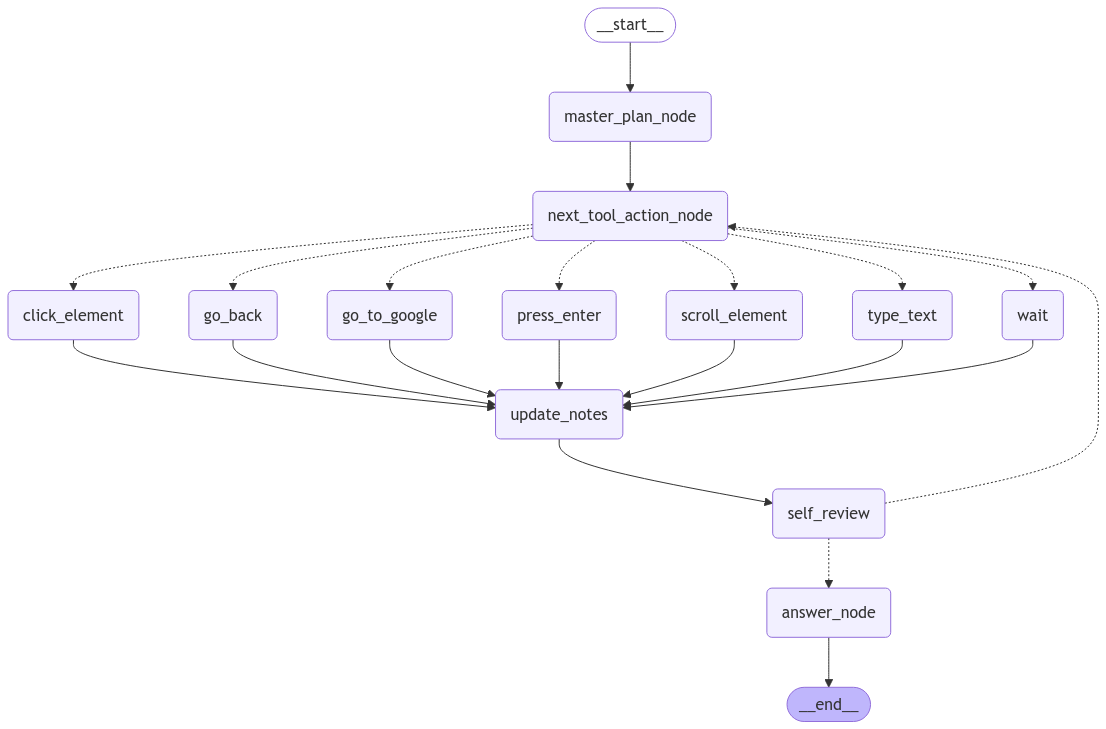

In [199]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END



builder = StateGraph(AgentState)

builder.add_node("master_plan_node", master_plan_node)
builder.add_node("next_tool_action_node", next_tool_action_node)
builder.add_node("click_element", click_element)
builder.add_node("scroll_element", scroll_element)
builder.add_node("type_text", type_text)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_google", go_to_google)
builder.add_node("press_enter", press_enter)
builder.add_node("update_notes", update_notes_node)
builder.add_node("self_review", self_review_node)
builder.add_node("answer_node", answer_node)


builder.add_edge(START, "master_plan_node")
builder.add_edge("master_plan_node", "next_tool_action_node")
builder.add_conditional_edges("next_tool_action_node", should_call_tool, ["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "press_enter"])

builder.add_edge("click_element", "update_notes")
builder.add_edge("scroll_element", "update_notes")
builder.add_edge("type_text", "update_notes")
builder.add_edge("wait", "update_notes")
builder.add_edge("go_back", "update_notes")
builder.add_edge("go_to_google", "update_notes")
builder.add_edge("press_enter", "update_notes")
builder.add_edge("update_notes", "self_review")
builder.add_conditional_edges("self_review", should_answer, ["answer_node", "next_tool_action_node"])
builder.add_edge("answer_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [200]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    try:
        # Increase timeout to 80 seconds and add wait_until option
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    return playwright, browser, page

config = {
        "configurable": {"thread_id": "1"},
    }



async def call_agent(task: str, go_to_page: str, max_steps: int = 250):
    playwright, browser, page = await setup_browser(go_to_page)
    final_answer = None

    try:
        event_stream = graph.astream(
            {
                "task": task, 
                "page": page, 
                "last_tool_action": "",
                "current_plan_executed": [],
                "status": "in_progress",
                "master_plan": [],
                "current_plan": [],
                "notes": []
            }, 
            {"recursion_limit": 400}
            
        )

        async for event in event_stream:
            if "next_tool_action_node" in event:
                action = event["next_tool_action_node"]
                print("Action: ", action["next_tool_action"]["description"])
                try:
                    display(Image("screenshot.png"))
                except:
                    print("No screenshot available")
            if "answer_node" in event:
                answer = event["answer_node"].get("answer")
                print("Answer: ", answer)
            
            
    finally:
        await browser.close()
        await playwright.stop()

    return answer
    




In [201]:
task = "Tucson AZ weather now"
go_to_page = "https://www.google.com"

final_answer = await call_agent(task, go_to_page)

********************MASTER PLAN NODE********************

----------------------------------------------------------

Master Plan:
{'plan': ['Go to Google',
          "Type 'Tucson AZ weather now' in the search bar and press enter",
          'Look for a reliable weather website link (like Weather.com, '
          'AccuWeather, or the National Weather Service)',
          'Click on the link to the weather website',
          'Scan the page for current weather conditions in Tucson, AZ',
          'Note down the temperature, weather conditions (sunny, rainy, etc.), '
          'and any relevant alerts or forecasts',
          'Summarize the current weather information for Tucson, AZ.']}
----------------------------------------------------------

********************NEXT TOOL ACTION NODE********************

[SystemMessage(content=' \n    You are an helpful assistant that can take in a broader master plan identify the next action that needs to be performed on the current web page.\n    Ca

KeyError: 'description'

In [174]:
from IPython.display import Markdown
Markdown(final_answer)

### Current Weather in Tucson, AZ

- **Temperature:** 9°C
- **Time:** Friday, 9:00 pm

### Upcoming Hourly Forecast

- **Saturday, 12:00 am:** 6°C
- **Saturday, 3:00 am:** 4°C
- **Saturday, 6:00 am:** 2°C
- **Saturday, 9:00 am:** 6°C
- **Saturday, 12:00 pm:** 13°C
- **Saturday, 3:00 pm:** 16°C
- **Saturday, 6:00 pm:** 13°C

### Weekly Forecast

- **Friday:** High 16°C, Low 2°C
- **Saturday:** High 16°C, Low 2°C
- **Sunday:** High 17°C, Low 2°C
- **Monday:** High 15°C, Low 1°C
- **Tuesday:** High 14°C, Low -1°C
- **Wednesday:** High 17°C, Low 0°C
- **Thursday:** High 17°C, Low 1°C
- **Next Friday:** High 18°C, Low 4°C

Stay warm and plan accordingly!